# Seq2Seq with Attention

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import dataset with 70K pairs of commands

In [2]:
source = open('data/commands_source_en_70k.txt', encoding='UTF-8').read().strip().split('\n')  
target = open('data/commands_target_en_70k.txt', encoding='UTF-8').read().strip().split('\n')   

Add extra number pairs (1k). PS: using 10K will introduce quite a lot noise to dictionary

In [3]:
# add numbers
source_num = open('data/nums_source_en_10k.txt', encoding='UTF-8').read().strip().split('\n')  
target_num = open('data/nums_target_en_10k.txt', encoding='UTF-8').read().strip().split('\n') 
source.extend(source_num[:1000])
target.extend(target_num[:1000])

In [4]:
import pandas as pd
data = pd.DataFrame(list(zip(target, source)), columns=["src", "tgt"])
data.head()

,src,tgt
0,is it warm in algund at two fifty five,is it warm in Algund at 02:55
1,how warm will it get,how warm will it get
2,how hot is it,how hot is it
3,how warm will it get at nineteen fifty eight,how warm will it get at 19:58
4,I would like to know how cold it is,I would like to know how cold it is


In [5]:
li = random.choices(data.src.unique(), k = int(len(data.src.unique()) *0.1 ))
train_df = data[~data.src.isin(li)]
test_df = data[data.src.isin(li)]

print("test size: {} unique sentences".format(len(li)))
print("train size: {} sample senteces (with duplication)".format(sum(~data.src.isin(li))) )

test size: 3155 unique sentences
train size: 63938 sample senteces (with duplication)


In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([\:])", r" : ", s)
    s = re.sub(r"([\.])", r" . ", s)
#     s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s

In [8]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s), normalizeString(t) ]for s, t in list(zip(lang1, lang2))] 

    input_lang = Lang('src')
    output_lang = Lang('tgt')

    return input_lang, output_lang, pairs

In [9]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
#     pairs = filterPairs(pairs)
#     print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(train_df.src.tolist(), train_df.tgt.tolist())
print(random.choice(pairs))

Reading lines...
Read 63938 sentence pairs
Counting words...
Counted words:
src 5965
tgt 7122
['will it rain today', 'will it rain today']


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=30):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, method='bow'):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=30):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [17]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def evaluate(encoder, decoder, sentence, max_length=30):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 40s (- 31m 56s) (3000 5%) 3.3483
3m 20s (- 30m 8s) (6000 10%) 1.5996
5m 2s (- 28m 35s) (9000 15%) 1.2391
6m 43s (- 26m 53s) (12000 20%) 1.0781
8m 26s (- 25m 19s) (15000 25%) 0.9210
10m 10s (- 23m 44s) (18000 30%) 0.8447
11m 56s (- 22m 11s) (21000 35%) 0.7295
13m 42s (- 20m 33s) (24000 40%) 0.7511
15m 25s (- 18m 51s) (27000 45%) 0.6457
17m 11s (- 17m 11s) (30000 50%) 0.6360
18m 56s (- 15m 29s) (33000 55%) 0.6764
20m 39s (- 13m 46s) (36000 60%) 0.6187
22m 24s (- 12m 4s) (39000 65%) 0.5719
24m 10s (- 10m 21s) (42000 70%) 0.5280
25m 55s (- 8m 38s) (45000 75%) 0.5281
27m 40s (- 6m 55s) (48000 80%) 0.5881
29m 25s (- 5m 11s) (51000 85%) 0.5073
31m 11s (- 3m 27s) (54000 90%) 0.4843
32m 58s (- 1m 44s) (57000 95%) 0.4966
34m 43s (- 0m 0s) (60000 100%) 0.4793


<Figure size 432x288 with 0 Axes>

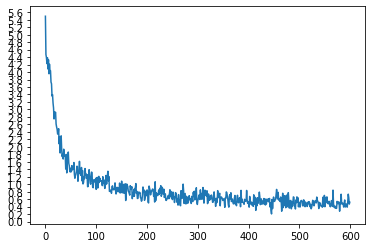

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 60000, print_every=3000, learning_rate=0.01)

In [21]:
# evaluate in training set
evaluateRandomly(encoder1, attn_decoder1)

> how is the weather forecast for tremezzo
= how is the weather forecast for tremezzo
< how is the weather forecast for tremezzo <EOS>

> i would like to watch amok
= i would like to watch amok
< i would like to watch <EOS>

> how is the weather going to be
= how is the weather going to be
< how is the weather going to be <EOS>

> will i freeze
= will i freeze
< will i freeze <EOS>

> search for jupiler pro league
= search for jupiler pro league
< search for jupiler pro league <EOS>

> please search for lily's driftwood bay
= please search for lily's driftwood bay
< please search for jupiler : <EOS>

> can you tell me if i should take an umbrella with me
= can you tell me if i should take an umbrella with me
< can you tell me if i should take an umbrella with me <EOS>

> turn on tv channel ten
= turn on tv channel 10
< turn on tv channel 10 <EOS>

> i want to change the station to radio channel flower power radio
= i want to change the station to radio channel flower power radio
< i wa

In [41]:
# evaluate in validation set
from jiwer import wer
from tqdm import tqdm 

def evaluateWER(encoder, decoder, n=10):
    WER = 0
    size = 0
    for test_pair in tqdm(test_pairs):
        try:
            output_words, attentions = evaluate(encoder, decoder, test_pair[0])
            output_sentence = ' '.join(output_words[:-1])
            WER += wer(test_pair[1], output_sentence)
            size += 1
        except:
            pass
    print("WER: {}".format(WER/ size))
    for i in range(n):
        try:
            test_pair = random.choice(test_pairs)
            print('>', test_pair[0])
            print('=', test_pair[1])
            output_words, attentions = evaluate(encoder, decoder, test_pair[0])
            output_sentence = ' '.join(output_words)
            print('<', output_sentence)
            print('')
        except:
            pass

test_pairs = [[normalizeString(s), normalizeString(t) ]for s, t in list(zip(test_df.drop_duplicates().src, test_df.drop_duplicates().tgt))] 
evaluateWER(encoder1, attn_decoder1, n=10)

100%|██████████| 3037/3037 [00:38<00:00, 79.26it/s] 


WER: 0.19248487024797356
> turn on netatmo in the bedroom
= turn on netatmo in the bedroom
< turn on netatmo in the bedroom <EOS>

> how much will it rain at twenty one thirteen in st martin in passeier
= how much will it rain at 21 : 13 in st-martin in passeier
< how much will it rain at 21 : 13 in st-martin in passeier <EOS>

> please turn on device hue ambiance spot one
= please turn on device hue ambiance spot 1
< please turn on device hue ambiance spot 1 <EOS>

> four hundred and twenty eight
= 428
< 532 <EOS>

> is it raining on fifteenth september
= is it raining on 15 . 9
< is it raining on 15 . 9 <EOS>

> go to channel seventy seven
= go to channel 77
< go to channel 77 <EOS>

> turn on regression
= turn on regression
> is it going to be nice outside at seventeen fifteen in milan
= is it going to be nice outside at 17 : 15 in milan
< is it going to be nice outside at 15 : 17 in milan <EOS>

> look for buena vista social club adios
= look for buena vista social club :  adios
< 

input = is it going to be nice outside at seventeen fifteen in milan
output = is it going to be nice outside at 15 : 17 in milan <EOS>


<ipython-input-43-d0f1824d29dc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-43-d0f1824d29dc>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


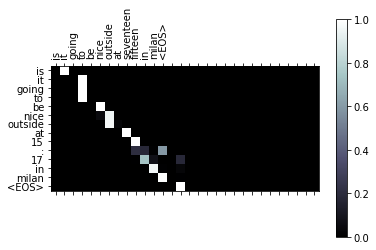

input = tell me something about real betis sevilla
output = tell me something about real jackson game <EOS>


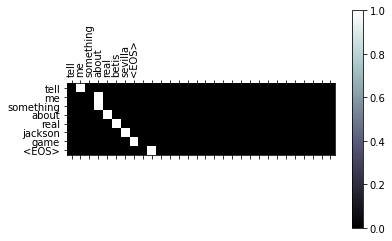

input = is it raining on fifteenth september
output = is it raining on 15 . 9 <EOS>


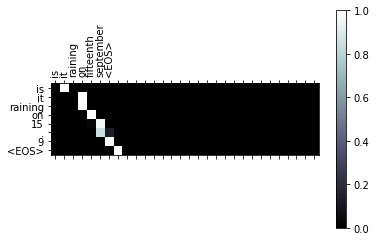

input = four hundred and twenty eight
output = 532 <EOS>


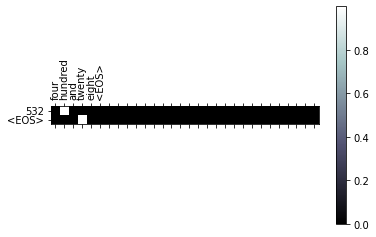

In [43]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("is it going to be nice outside at seventeen fifteen in milan")
evaluateAndShowAttention("tell me something about real betis sevilla")
evaluateAndShowAttention("is it raining on fifteenth september")
evaluateAndShowAttention("four hundred and twenty eight")

In [44]:
embeddings_dict = {}
with open("/home/zhechensu/glove/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [45]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'/gdrive/My Drive/glove.6B/6B.50.dat', mode='w')
 
with open(f'/gdrive/My Drive/glove.6B/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
     
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'/gdrive/My Drive/glove.6B/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'/gdrive/My Drive/glove.6B/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'/gdrive/My Drive/glove.6B/6B.50_idx.pkl', 'wb'))

array([ 0.24861 , -0.37992 ,  0.90709 , -0.24283 ,  0.41397 ,  0.29452 ,
        0.46014 , -0.59381 ,  0.034256, -0.33302 , -1.2157  , -0.53273 ,
        0.42819 , -0.78494 ,  0.1835  , -1.0465  , -0.41301 ,  0.23301 ,
       -0.52422 ,  0.68597 , -0.13336 , -0.62924 ,  0.62042 , -0.3149  ,
       -0.017245,  0.54963 ,  0.43892 , -0.33399 , -0.27343 , -0.37997 ,
        0.3367  ,  0.11261 ,  1.0372  ,  1.0415  ,  0.64125 , -0.12848 ,
        0.55627 ,  0.20363 , -0.14634 ,  0.19242 , -0.30059 , -0.50745 ,
        1.0043  ,  0.481   , -1.0141  ,  0.89509 , -0.43524 ,  0.1536  ,
        0.088555, -0.1082  ], dtype=float32)

## issue1: unkown mapping -> larger dataset

In [55]:
evaluateAndShowAttention("change to radio channel forty two please")

input = change to radio channel forty two please
output = change to radio channel 40 please <EOS>


## issue2: unkown words -> GloVe

In [42]:
evaluateAndShowAttention("i'd like to watch lord of the ring")

input = i'd like to watch lord of the ring
output = i'd like to watch ice the the <EOS>


In [46]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
 
def load_variable(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

save_variable(encoder1, 'models/s2s_60k+1k_encoder.pkl') 
save_variable(attn_decoder1, 'models/s2s_60k+1k_decoder.pkl') 

'models/s2s_60k+1k_decoder.pkl'

Evaluation for 70K model

In [47]:
name = '60k+1k' #{'70k', '60k+1k'}
a = load_variable('models/s2s_{}_encoder.pkl'.format(name))
b = load_variable('models/s2s_{}_decoder.pkl'.format(name))
evaluateRandomly(a, b)

> i would like to know if it is raining in schlanders on twenty sixth may
= i would like to know if it is raining in schlanders on 26 . 5
< i would like to know if it is raining in schlanders on 26 . 5 <EOS>

> play the movie vienna empire dynasty and dream
= play the movie vienna :  empire, dynasty and dream
< play the movie inside el and - :   .  .  .  .  .  .  .  <EOS>

> do you know if it will be windy on twenty second october
= do you know if it will be windy on 22 . 10
< do you know if it will be windy on 22 . 10 <EOS>

> i do not want to listen to this
= i do not want to listen to this
< i do not want to listen to this <EOS>

> can you tell me the temperature for on seventeenth august
= can you tell me the temperature for on 17 . 8
< can you tell me the temperature for on 17 . 8 <EOS>

> search for radio bern one rock
= search for radio bern1 rock
< search for radio bern1 rock <EOS>

> i want to turn on device swisscom box one
= i want to turn on device swisscom box 1
< i want t

/home/zhechensu/miniconda3/envs/pp/lib/python3.8/site-packages/torch/nn/modules/rnn.py:734: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


< is there thunder <EOS>

> is it pouring
= is it pouring
< is it pouring <EOS>

